In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn.linear_model
import xgboost as xgb
from pytil.object import Namespace as O
from pytil.utility import *
from helpers import *
from pytil.quickvis import canvas

import random
ss = slice(None)
canvas(16, 2)

In [2]:
N_TRAIN, N_TEST = 623817, 640430
df = pd.read_csv('train.csv', index_col=0)
df.index = df.index - N_TRAIN
dg = pd.read_csv('test.csv', index_col=0)
dh = pd.concat([df, dg])
n_stock = len(set(dh.Stock))

# Explore

In [3]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()
idfeats = 'Market Stock'.split()

In [ ]:
raise Exception("Don't go on blindly!")

## feature explore

In [ ]:
sortdh = dh.sort_values('Day')
res = [None] * n_stock
for idx, ((markt, stock), td) in enumerate(sortdh.groupby(['Market', 'Stock'])):
    data = [np.inf]
    for i in range(1, 200):
        roll = td.rolling(i, center=True, min_periods=1)
        est = (roll.y.sum() - td.y) / (roll.y.count() - 1)
        data.append((td.Weight * (est - td.y) ** 2).sum())
    res[stock] = min(range(len(data)), key=lambda x: data[x])
    if idx % 100 == 0:
        print(idx)

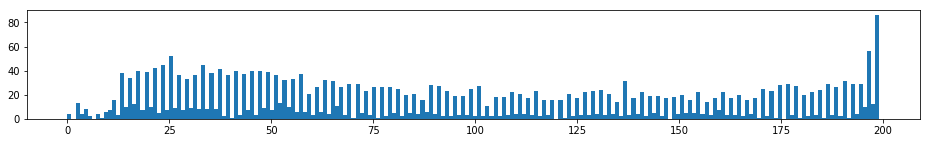

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:18:24.639794. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [542]:
plt.hist(res, bins=200);

In [ ]:
13, 25, 33, 57

## old things

In [724]:
agrp = np.abs(df).groupby('Market Stock'.split())
wycorr = agrp.corr().loc[(slice(None), slice(None), 'Weight',), ('y',)]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:16.747078. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


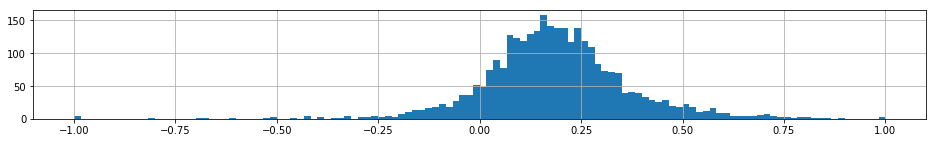

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:31.051520. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [725]:
res = agrp.corr().loc[(ss, ss, 'y'), 'x4']
res.hist(bins=120)

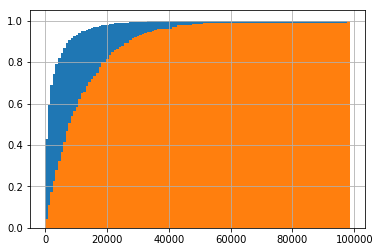

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 09:11:33.695777. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [341]:
hist(grp.sum().Weight, bins=120, normed=True, cumulative=True)
hist(grp.sum().Weight, weighted=True, bins=120, normed=True, cumulative=True)

In [394]:
listthing = [int(x[0]) for x in sorted(df[['Stock', col]].values, key=lambda x: x[1])[::-1][-1000:-500]]
thing = list(set(listthing))

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 10:21:28.672423. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


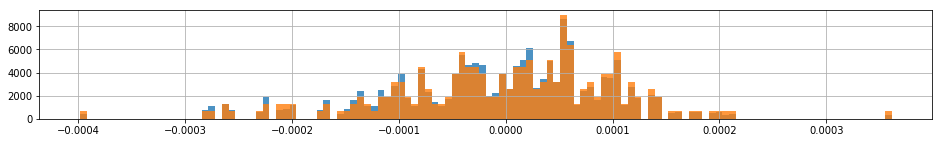

247 0.000397538089951


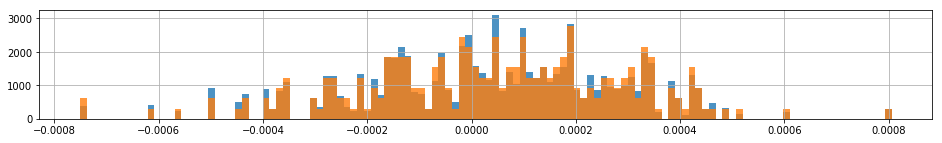

251 0.0867626267151


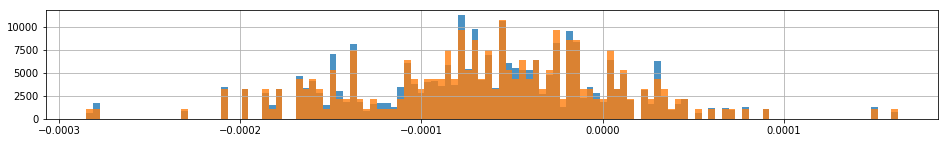

251 0.204674285411


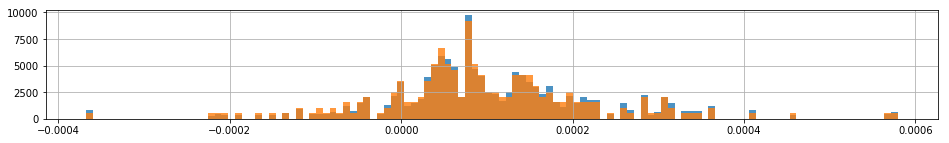

247 1.42622882884e-05


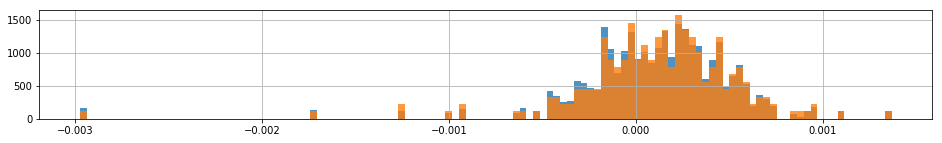

247 1.6676556502e-31


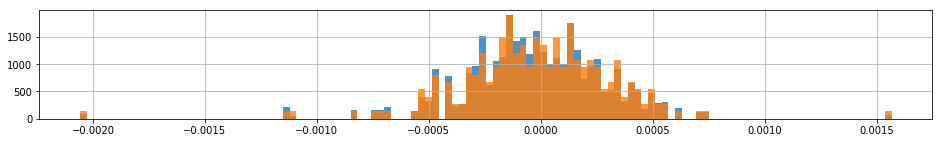

247 9.22979973834e-14


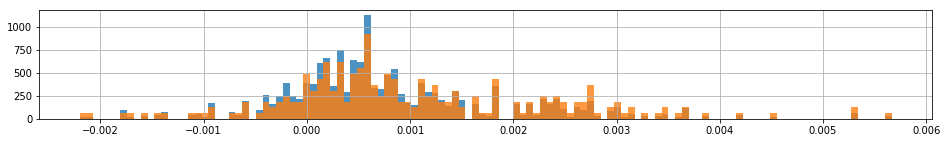

249 9.59286090927e-06


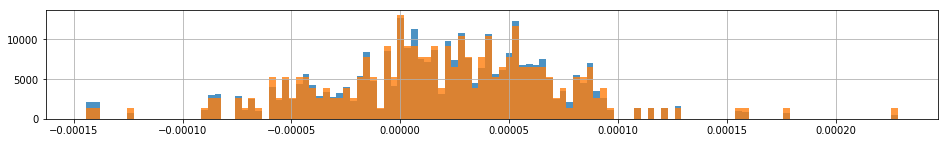

247 0.0197578412492


C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:25:03.178891. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [744]:
col = 'y'
from scipy import stats
ii = list(range(df.Stock.min(), df.Stock.max() + 1))
random.shuffle(ii)
ii = ii[:8]
#ii = thing
for i in range(len(ii)):
    q = df.query('Stock == ' + str(ii[i]))
    trans = q[col]
    trans.hist(bins=120, weights=q.Weight, normed=True, alpha=.8)
    trans.hist(bins=120, normed=True, alpha=.8)
    plt.show()
    print(len(trans), stats.normaltest(trans).pvalue)

## cv days selection

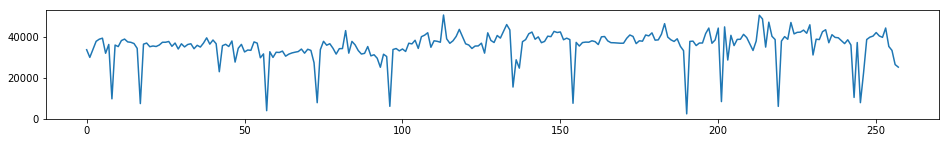

In [4]:
days = sorted(set(df.Day))
weights = [df.query('Day == ' + str(day)).Weight.sum() for day in days]
plt.plot(weights); plt.show()

# Simple model

In [8]:
# +2 to day to get 0 % 7 == Monday

In [4]:
market = pd.get_dummies(dh[['Market']], columns=['Market'])
#stock = pd.get_dummies(dh[['Stock']], columns=['Stock'])
#day = pd.get_dummies(dh[['Day']], columns=['Day'])

In [5]:
dayseg = dh['Day']
off0 = (dayseg + 2) // 14
off0.name = 'Biweek0'
off1 = (dayseg + 2 + 7) // 14
off1.name = 'Biweek1'
dayseg = pd.concat([off0, off1], axis=1)

In [6]:
wkdfeats = 'Monday Tuesday Wednesday Thursday Friday'.split()
weekday = ((dh.Day + 2) % 7)
weekday = weekday.map({i: s for i, s in enumerate(wkdfeats)})
weekday = pd.get_dummies(weekday)
weekday = weekday[wkdfeats]

In [7]:
count = dh.groupby(['Market', 'Stock']).Stock.transform('count')
count.name = '$ count'

In [8]:
xaggs = O()
for agg in ['mean', 'median', 'min', 'max', 'std', 'mad', 'skew', 'kurtosis']:
    if agg == 'kurtosis':
        xa = dh.groupby(['Market', 'Stock'])[xfeats].transform(pd.DataFrame.kurt)
    else:
        xa = dh.groupby(['Market', 'Stock'])[xfeats].transform(agg)
    xa.columns = ['$ ' + c + ' ' + agg for c in xa.columns]
    xaggs[agg] = xa
xagg = pd.concat([xaggs[agg] for agg in xaggs], axis=1)

In [9]:
zscore = (dh[xfeats] - xaggs.mean.values) / xaggs.std.values
zscore.columns = [c + ' $ z-score' for c in zscore.columns]
mscore = (dh[xfeats] - xaggs.median.values) / xaggs.mad.values
mscore.columns = [c + ' $ m-score' for c in mscore.columns]

In [10]:
rank = 1 - dh.groupby(['Market', 'Stock'])[xfeats].transform(lambda x: x.rank(pct=True, method='max', ascending=False))
rank.columns = [c + ' $ rank' for c in rank.columns]

In [11]:
# TODO below code inefficient due to the unoptimized y[trfilt]

In [26]:
trfilt = dh.Day.isin(days_a)
#trfilt = dh.Day == dh.Day
def helper(y):
    thing = y + np.nan
    thing.loc[trfilt] = y[trfilt]
    return thing

In [27]:
# legacy
ymean = dh.groupby(['Market', 'Stock']).y.transform(lambda y: helper(y).mean())
ymean = ymean.fillna(0)
ymean.name = '$ y mean'

In [12]:
dh_cop = dh.copy() #helper(dh)
dh_cop['wy'] = dh.y * dh.Weight
grp = dh_cop.groupby(['Stock'])
wsum = grp.Weight.sum()
wy = grp.wy.sum()
ymean = wy / wsum
ymean = ymean.fillna(0)
ymean = dh.Stock.map(ymean)
ymean.name = '$ y mean'
#apply(lambda v: (lambda h: (h.y * h.Weight).sum() / h.Weight.sum())(helper(v)))

In [169]:
def get_rolling_average(x, window, *args, **kw):
    roll = x.rolling(window, min_periods=1, *args, **kw)
    est = (roll.sum() - x) / (roll.count() - 1)
    return est
timedh = dh.sort_values('Day')
timey = timedh.groupby(['Market', 'Stock']).y
yrolls = []
for w in range(5, 58, 4): #[13, 25, 33, 57]:
    roll = timey.transform(lambda y: get_rolling_average(helper(y), w, center=True))
    roll.name = 'y mean((' + str(w) + '))center'
    yrolls.append(roll)
    #roll = timey.transform(lambda y: get_rolling_average(y[::-1], w, center=False)[::-1])
    #roll.name = 'y mean((' + str(w) + '))after'
    #yrolls.append(roll)
    #roll = timey.transform(lambda y: get_rolling_average(y, w, center=False))
    #roll.name = 'y mean((' + str(w) + '))before'
    #yrolls.append(roll)

KeyboardInterrupt: 

In [11]:
aa = list(range(5, 58, 4))
aa.index(13), aa.index(25), aa.index(33), aa.index(57)

(2, 5, 7, 13)

In [13]:
windowdh = pd.concat([dh[idfeats], weekday, dh[xfeats], zscore, mscore, rank], axis=1)
windowgrp = windowdh.groupby(idfeats)
shifts = []
plains = []
for i in [-1, 1]: # <-- the shifts
    shifted = windowgrp.shift(i)
    if i:
        shifted.columns = [x + ' (' + str(-i) + ')' for x in shifted.columns]
    shifts.append(shifted)

In [172]:
#stockparts = []
#for i in range(80):
#    randmap = list(range(n_stock))
#    random.shuffle(randmap)
#    stockpart = dh.Stock.map(lambda x: randmap[x])
#    stockpart.name = 'Stock ~' + str(i) + '~'
#    stockparts.append(stockpart)

In [173]:
# 

In [174]:
#
try:
    with open('days_order.txt', 'r') as file:
        days = [int(x) for x in file.read().splitlines()]
except FileNotFoundError:
    days = sorted(set(df.Day))
    random.shuffle(days)
    print('new days')
    with open('days_order.txt', 'w') as file:
        print('\n'.join(str(x) for x in days), file=file)
#
n_days = len(days)
#days_a, days_b, days_c = set(days[:n_days // 3]), set(days[n_days // 3:(2 * n_days) // 3]), set(days[(2 * n_days) // 3:])
days_a, days_b = set(days[:n_days // 2]), set(days[n_days // 2:])
#tr, cv, sc = df.Day.isin(days_a), df.Day.isin(days_b), df.Day.isin(days_c)
tr, cv = df.Day.isin(days_a), df.Day.isin(days_b)

In [23]:
#origdh = dh[['Market'] + xfeats]
#thedh = pd.concat([market, stock, weekday, origdh], axis=1)
thedh = pd.concat([dh[xfeats], market, dayseg, weekday, count, xagg, zscore, mscore, rank, ymean] + shifts, axis=1)

In [34]:
xdf = thedh.iloc[:N_TRAIN]
labels = list(xdf.columns)
n = len(df)
x = xdf.values
y = df.y.values #(df.y - ymean).values
y = 10000 * y #(y - ymean[:N_TRAIN].values)
weight = df.Weight.values

In [35]:
#n = len(df)
#a = list(range(n))
#random.shuffle(a)
#tr, cv = a[:n // 2], a[n // 2:]

In [36]:
dmat = O()
#dmat.tr = xgb.DMatrix(x[tr], y[tr], feature_names=labels, weight=weight[tr])
#dmat.cv = xgb.DMatrix(x[cv], y[cv], feature_names=labels, weight=weight[cv])
#dmat.sc = xgb.DMatrix(x[sc], y[sc], feature_names=labels, weight=weight[sc])
dmat.given = xgb.DMatrix(x, y, feature_names=labels, weight=weight)

In [37]:
model = None
boost_hp = dict(
    objective = 'reg:linear',
    booste = 'gbtree',
    max_depth = 3, #12,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    tree_method = 'hist',
    gamma = 50.00003,
    min_child_weight = 1000,
    eta = 0.1,
    seed = 0
)
cv_hp = dict(
    num_boost_round = 300,
    early_stopping_rounds = 30,
    nfold = 10,
    stratified = True,
    seed = 0
)
learn_hp = dict(
    num_boost_round = 1450,
    #early_stopping_rounds = 100,
    #evals = [[dmat.tr, 'Train'], [dmat.cv, 'CV']]
)
model = xgb.train(boost_hp, dmat.given, **learn_hp)

In [38]:
model.eval(dmat.given) #y_

'[0]\teval-rmse:2.431233'

In [17]:
model.eval(dmat.given) #yy_

'[0]\teval-rmse:2.426298'

In [ ]:
# hist and with new features
[263]	Train-rmse:2.26093	CV-rmse:2.55236 depth9
#
[299]	Train-rmse:2.32913	CV-rmse:2.55080 depth7
[330]	Train-rmse:2.36998	CV-rmse:2.55071 depth6
[678]	Train-rmse:2.32489	CV-rmse:2.54711 depth5
[925]	Train-rmse:2.37503	CV-rmse:2.54696 depth4
[2017]	Train-rmse:2.38538	CV-rmse:2.54491 depth3
[3562]	Train-rmse:2.51268	CV-rmse:2.55910 depth2

In [ ]:
[1312]	Train-rmse:2.4278	CV-rmse:2.53536 depth3 

In [ ]:
[100]	Train-rmse:2.50238	CV-rmse:2.5416

In [ ]:
239685 256708 [370] depth9
237573 256405 [356] depth9 @withmeans
239055 256313 [314] depth9 @zeromeaned
236928 256113 [380] depth9 @zeromeaned @stocks

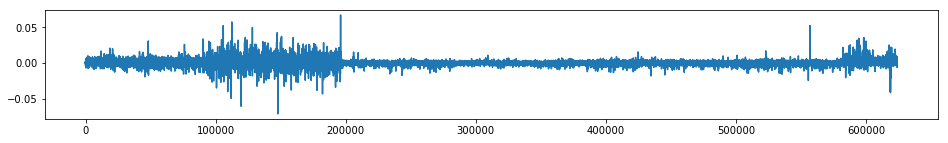

In [72]:
plt.plot(df.y.values);

In [18]:
y = df.y.values

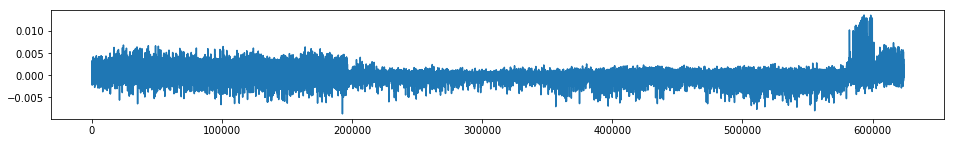

In [39]:
y_ = model.predict(dmat.given)
y_ /= 10000
#y_ += ymean[:N_TRAIN]
plt.plot(y_);

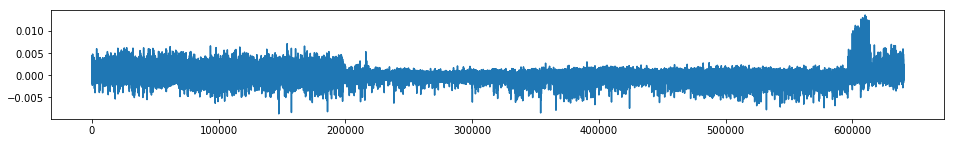

In [40]:
xtest = thedh.iloc[N_TRAIN:].values
dmat.test = xgb.DMatrix(xtest, feature_names=labels)
ytest_ = model.predict(dmat.test)
ytest_ /= 10000
#ytest_ += ymean[N_TRAIN:]
plt.plot(ytest_);

In [30]:
ypred = pd.Series(ytest_).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model2.csv', header=True)
#with open('days_order.txt', 'w') as file:
#    print('\n'.join(str(x) for x in days), file=file)
#omodel = model
#odays = days
#oy_ = y_
#oytest_ = ytest_

In [31]:
yy = (oytest_ + ytest_) / 2
ypred = pd.Series(yy).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model3.csv', header=True)

In [41]:
the = df.copy()
the['y_'] = y_
the['yy_'] = yy_
wsum = the.groupby(the.Stock).apply(lambda x: x.Weight.sum())
y_wse = the.groupby(the.Stock).apply(lambda x: ((x.y_ - x.y) ** 2 * x.Weight).sum())
yy_wse = the.groupby(the.Stock).apply(lambda x: ((x.yy_ - x.y) ** 2 * x.Weight).sum())

In [46]:
use_y_not_yy = y_wse < yy_wse
use_y = dh.Stock.map(use_y_not_yy)
use_yy = dh.Stock.map(~use_y_not_yy)

In [58]:
yyy = ytest_ * use_y[N_TRAIN:] + yytest_ * use_yy[N_TRAIN:]
yyy.iloc[43289] = (ytest_[43289] + yytest_[43289]) / 2
ypred = pd.Series(yyy).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model3.csv', header=True)

In [144]:
i = 2260

In [145]:
y_wse[i:i+10]

Stock
2263    0.000129
2264    0.000010
2265    0.000124
2266    0.000222
2267    0.000009
2268    0.000281
2269    0.000080
2270    0.000008
2271    0.000041
2272    0.000036
dtype: float64

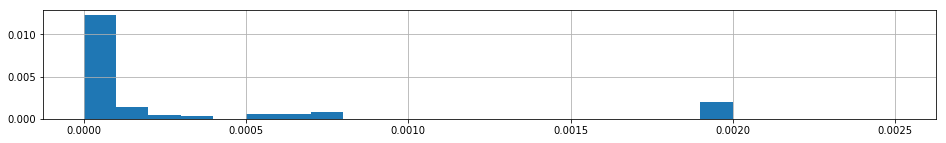

In [132]:
hist((y_wse - yy_wse).abs(), weighted=True, bins=np.arange(0, 0.0026, 0.0001));

In [38]:
sorted(model.get_score().items(), key=lambda x: -x[1])

[('x3D', 488),
 ('x3E', 352),
 ('x4', 322),
 ('x3A', 293),
 ('x5', 270),
 ('$ x4 min', 266),
 ('x0', 200),
 ('x4 (1)', 197),
 ('x4 (-1)', 185),
 ('Biweek0', 185),
 ('x3B', 162),
 ('x5 (-1)', 152),
 ('x5 (1)', 152),
 ('$ x5 median', 151),
 ('x3C', 137),
 ('x3D $ rank', 120),
 ('x3E (-1)', 117),
 ('x3D $ z-score', 117),
 ('Stock', 114),
 ('x3A (1)', 113),
 ('$ x2 min', 112),
 ('x3E $ m-score', 111),
 ('$ x1 min', 106),
 ('x3D (1)', 106),
 ('$ x4 median', 105),
 ('$ x2 mean', 92),
 ('x3A (-1)', 92),
 ('x3A $ rank', 86),
 ('x3E (1)', 84),
 ('x3C (-1)', 83),
 ('$ x3E median', 82),
 ('x3B (-1)', 82),
 ('x2', 77),
 ('$ x5 mad', 76),
 ('x1', 75),
 ('$ x1 mean', 75),
 ('x3E $ rank', 74),
 ('x0 $ m-score', 74),
 ('x3D (-1)', 73),
 ('x3E $ z-score', 72),
 ('$ x4 std', 72),
 ('x2 (1)', 72),
 ('$ x3D max', 70),
 ('$ x5 min', 69),
 ('x6 (-1)', 69),
 ('x0 $ z-score', 68),
 ('x3D $ m-score', 68),
 ('$ x4 mean', 68),
 ('$ x2 median', 68),
 ('x5 $ rank', 66),
 ('Market_3', 65),
 ('x3A $ z-score', 64),
 

In [55]:
for i, tree in enumerate(model.get_dump()):
    print('<{}>'.format(i))
    print(tree)
    if i >= 10:
        break

AttributeError: 'NoneType' object has no attribute 'get_dump'

## predict y-rank

# Split model

# Abs model